# Import all necessary libraries and set important global variables

In [22]:
import tensorflow as tf
%load_ext tensorboard
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.8.4'

In [26]:
import sys
print(sys.path)

['/home/jupyter', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter/.ipython']


In [16]:
from typing import List, Tuple
import tensorflow as tf
from keras.engine.sequential import Sequential
from urllib.request import urlretrieve
from pathlib import Path
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
import os
import itertools
from sklearn.utils import shuffle
from urllib.parse import quote
from typing import Callable, List, Tuple
import numpy as np
from datetime import datetime
from packaging import version
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
cnn_model_path: str = "models/cnn_trained_model.h5"
rnn_model_path: str = "models/rnn_trained_model.h5"
image_dims: Tuple[int, int] = (28, 28)
classes_path_100: str = "classes/100_classes.txt"
classes_path_all: str = "classes/all_classes.txt"
dataset_url: str = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
dataset_path: str = "data/"

# Functions for loading in and dealing with data from google bucket

In [ ]:
def load_model() -> Sequential:
    """Loads the trained model from the specified local path.

    Returns:
        Sequential: The loaded model.
    """
    return tf.keras.models.load_model(trained_model_path)

def load_classes(num_classes: str = "100") -> List[str]:
    """Loads the class names from the specified local path.

    Args:
        num_classes (str): Specifies the number of classes to be loaded (can be '100' or 'all').
    Returns:
        List[str]: A list of class names sorted alphabetically.
    """
    with open(
        classes_path_100
        if num_classes == "100"
        else classes_path_all,
        "r",
    ) as f:
        classes = [class_name.rstrip("\n") for class_name in f]
    return sorted(classes)

def _create_dataset_directory():
    """Create a local directory to store the downloaded dataset.
    """
    Path(dataset_path).mkdir(parents=True, exist_ok=True)
    
def download_dataset(class_names: List[str]):
    """Downloads the Quickdraw dataset by Google.

    Args:
        class_names (List[str]): A List of clases whose data needs to be downloaded.
    """
    _create_dataset_directory()
    for index, class_name in tqdm(enumerate(class_names), total=len(class_names)):
        class_url = class_name.replace("_", "%20")
        url = dataset_url + class_url + ".npy"
        local_path = quote(dataset_path + class_name + ".npy")
        urlretrieve(url, local_path)


def load_dataset(num_samples_per_class: int = 16000, test_size: float = 0.33) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Loads the downloaded data.
    Args:
        num_samples_per_class (int, optional): The number of images to be used from each class for training. Defaults to 16000.
        test_size (float, optional): The percentage of images to be used for testing. Defaults to 0.33.
    Returns:
        np.ndarray: Train data.
        np.ndarray: Train labels.
        np.ndarray: Test data.
        np.ndarray: Test labels.
    """
    dataset = sorted(glob.glob(os.path.join(dataset_path, "*.npy")))
    
    # Load all images into a single 2D array
    images = np.array(list(itertools.chain.from_iterable([np.load(f)[:num_samples_per_class] for f in dataset])))
    labels = np.array(list(itertools.chain.from_iterable([np.full((num_samples_per_class,), i) for i, f in enumerate(dataset)])))

    # Shuffle the data and split into train and test sets
    X, y = shuffle(images, labels, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, y_train, X_test, y_test

In [ ]:
class_names = load_classes('all')
print(class_names)

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'aircraft_carrier', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball_bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'c

In [6]:
#download_dataset(class_names)

In [7]:
X_train, y_train, X_test, y_test = load_dataset(num_samples_per_class=23000, test_size=0.3)

# Here is what a random sample looks like

(28, 28, 1)


ValueError: can only convert an array of size 1 to a Python scalar

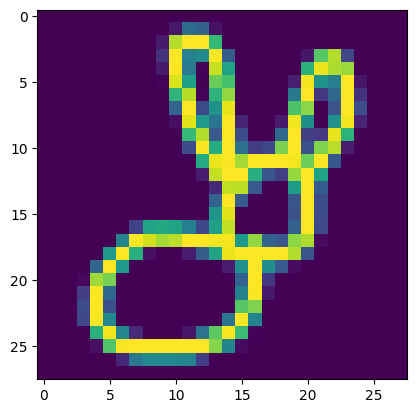

In [36]:
%matplotlib inline  
idx = randint(0, len(X_train))
print(X_train[idx].shape)

plt.imshow(X_train[idx].reshape(28, 28)) 
print(class_names[int(y_train[idx].item())])

# Preprocessing Functionality

In [23]:
#%pip install opencv-python
from utils import (
    training_normalize_pixel_values,
    training_reshape_image,
    one_hot_encode_labels,
)


class PreProcessor:
    """A class which preprocesses the data.
    """

    def __init__(self) -> None:
        self.train_pipeline: List[Callable] = [
            training_reshape_image,
            training_normalize_pixel_values,
            one_hot_encode_labels,
        ]

    def train_preprocess(
        self,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Runs the training pipeline on the dataset.

        Args:
            X_train (np.ndarray): Train data.
            X_test (np.ndarray): Test data.
            y_train (np.ndarray): Train labels.
            y_test (np.ndarray): Test labels.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: The preprocessed dataset.
        """
        for job in self.train_pipeline:
            X_train, X_test, y_train, y_test = job(X_train, X_test, y_train, y_test)
        return X_train, X_test, y_train, y_test

In [10]:
P = PreProcessor()
X_train, X_test, y_train, y_test = P.train_preprocess(X_train, X_test, y_train, y_test)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (5554500, 28, 28, 1), X_test: (2380500, 28, 28, 1), y_train: (5554500, 345), y_test: (2380500, 345)


# Model 1: Convolutional Neural Network (CNN)

In [11]:
model = keras.Sequential()

model.add(layers.Convolution2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax')) 

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

2023-03-23 14:28:23.504212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-23 14:28:23.504287: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 14:28:23.504314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cnn-based-classifier): /proc/driver/nvidia/version does not exist
2023-03-23 14:28:23.504706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild

In [12]:
logdir = "logs/cnn/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
model.fit(x = X_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=25, callbacks=[tensorboard_callback])

2023-03-22 16:08:55.681362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15677020800 exceeds 10% of free system memory.
2023-03-22 16:09:05.070855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6898689000 exceeds 10% of free system memory.


Epoch 1/25
19526/19528 [============================>.] - ETA: 0s - loss: 2.0379 - top_k_categorical_accuracy: 0.7833

2023-03-22 16:18:20.926786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1741891200 exceeds 10% of free system memory.
2023-03-22 16:18:21.644452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 766521000 exceeds 10% of free system memory.


19528/19528 [==============================] - 573s 29ms/step - loss: 2.0379 - top_k_categorical_accuracy: 0.7833 - val_loss: 1.7213 - val_top_k_categorical_accuracy: 0.8340
Epoch 2/25
19528/19528 [==============================] - 572s 29ms/step - loss: 1.6678 - top_k_categorical_accuracy: 0.8409 - val_loss: 1.6184 - val_top_k_categorical_accuracy: 0.8484
Epoch 3/25
19528/19528 [==============================] - 570s 29ms/step - loss: 1.6028 - top_k_categorical_accuracy: 0.8497 - val_loss: 1.5889 - val_top_k_categorical_accuracy: 0.8523
Epoch 4/25
19528/19528 [==============================] - 570s 29ms/step - loss: 1.5732 - top_k_categorical_accuracy: 0.8535 - val_loss: 1.5696 - val_top_k_categorical_accuracy: 0.8546
Epoch 5/25
19528/19528 [==============================] - 601s 31ms/step - loss: 1.5418 - top_k_categorical_accuracy: 0.8576 - val_loss: 1.5382 - val_top_k_categorical_accuracy: 0.8585
Epoch 7/25
19528/19528 [==============================] - 584s 30ms/step - loss: 1.531

In [13]:
model.save('cnn_trained_model.h5')

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {score[1] * 100}')

2023-03-22 20:11:50.804226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7465248000 exceeds 10% of free system memory.


Test accuracy: 86.29842400550842


In [27]:
from sklearn.metrics import classification_report
y_prediction = model.predict(X_test)
y_prediction = [class_names[x] for x in np.argmax(y_prediction, 1)]
y_true_labels = [class_names[x] for x in np.argmax(y_test,1)]
report = classification_report(y_true_labels,y_prediction)
#confusion = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_prediction)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_names) 
#cm_display.plot()
#plt.show()

In [45]:
print(report)

                         precision    recall  f1-score   support

       The_Eiffel_Tower       0.81      0.87      0.84      6939
The_Great_Wall_of_China       0.36      0.30      0.32      6815
          The_Mona_Lisa       0.73      0.77      0.75      6911
       aircraft_carrier       0.31      0.15      0.20      6990
               airplane       0.74      0.66      0.70      6952
            alarm_clock       0.72      0.66      0.69      6775
              ambulance       0.54      0.62      0.58      6844
                  angel       0.79      0.74      0.76      6910
       animal_migration       0.47      0.59      0.52      6941
                    ant       0.54      0.73      0.62      6928
                  anvil       0.85      0.74      0.79      6786
                  apple       0.80      0.87      0.83      6857
                    arm       0.68      0.47      0.55      6822
              asparagus       0.54      0.46      0.50      6919
                    axe 

[False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[[6237    0    0    0]
 [   0 6009    0    0]
 [   0    0 6192   11]
 [   0    0    2 6139]]


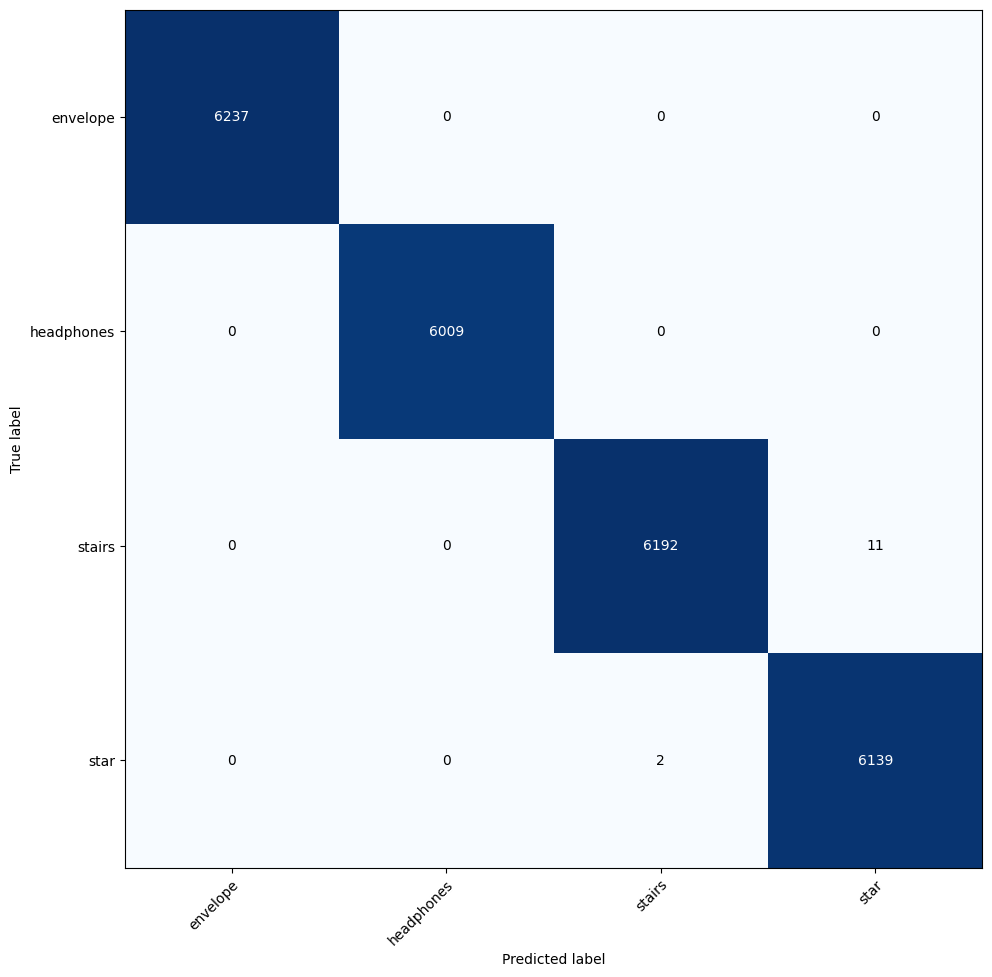

In [47]:
from sklearn.metrics import confusion_matrix
from itertools import compress
selected_classes = ["envelope", "headphones", "stairs", "star"]
mask = np.isin(y_prediction, selected_classes) & np.isin(y_true_labels, selected_classes)
print(mask[0:100])
cm = confusion_matrix(list(compress(y_true_labels, mask)), list(compress(y_prediction,mask)), labels=selected_classes)
print(cm)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=selected_classes, yticklabels=selected_classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

# Model 2: Recurrent Neural Network (RNN) with Convolutional layers

In [50]:
inputs = layers.Input(shape=X_train.shape[1:])
x = layers.Convolution2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Convolution2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Convolution2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)

x = layers.Reshape((1, -1))(x)
# Recurrent Layers

x = layers.LSTM(258, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.2)(x)


# Output Layer
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['top_k_categorical_accuracy'])

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 128)         7385

In [53]:
logdir = "logs/rnn/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
model.fit(x = X_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=25, callbacks=[tensorboard_callback])

Epoch 1/25
19528/19528 [==============================] - 1393s 71ms/step - loss: 2.0876 - top_k_categorical_accuracy: 0.7726 - val_loss: 1.4657 - val_top_k_categorical_accuracy: 0.8658
Epoch 2/25
19528/19528 [==============================] - 1364s 70ms/step - loss: 1.6475 - top_k_categorical_accuracy: 0.8418 - val_loss: 1.3683 - val_top_k_categorical_accuracy: 0.8777
Epoch 3/25
19528/19528 [==============================] - 1367s 70ms/step - loss: 1.5762 - top_k_categorical_accuracy: 0.8513 - val_loss: 1.3261 - val_top_k_categorical_accuracy: 0.8831
Epoch 4/25
19528/19528 [==============================] - 1386s 71ms/step - loss: 1.5406 - top_k_categorical_accuracy: 0.8558 - val_loss: 1.3127 - val_top_k_categorical_accuracy: 0.8841
Epoch 5/25
19528/19528 [==============================] - 1489s 76ms/step - loss: 1.5189 - top_k_categorical_accuracy: 0.8588 - val_loss: 1.2999 - val_top_k_categorical_accuracy: 0.8860
Epoch 6/25
19528/19528 [==============================] - 1463s 75ms/s

In [55]:
model.save('rnn_trained_model2.h5')

In [12]:
model = tf.keras.models.load_model("rnn_trained_model2.h5")
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {score[1] * 100}')

2023-03-23 09:37:57.421650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-23 09:37:57.421699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 09:37:57.421728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cnn-based-classifier): /proc/driver/nvidia/version does not exist
2023-03-23 09:37:57.422268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild

Test accuracy: 89.26204442977905


In [14]:
from sklearn.metrics import classification_report
y_prediction = model.predict(X_test)
y_prediction = [class_names[x] for x in np.argmax(y_prediction, 1)]
y_true_labels = [class_names[x] for x in np.argmax(y_test,1)]
report = classification_report(y_true_labels,y_prediction)
print(report)

2023-03-23 09:57:37.858777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7465248000 exceeds 10% of free system memory.


                         precision    recall  f1-score   support

       The_Eiffel_Tower       0.84      0.90      0.87      6939
The_Great_Wall_of_China       0.43      0.36      0.39      6815
          The_Mona_Lisa       0.81      0.83      0.82      6911
       aircraft_carrier       0.36      0.19      0.25      6990
               airplane       0.69      0.78      0.74      6952
            alarm_clock       0.79      0.74      0.77      6775
              ambulance       0.68      0.61      0.64      6844
                  angel       0.84      0.80      0.82      6910
       animal_migration       0.47      0.65      0.55      6941
                    ant       0.72      0.74      0.73      6928
                  anvil       0.82      0.81      0.81      6786
                  apple       0.81      0.89      0.85      6857
                    arm       0.68      0.66      0.67      6822
              asparagus       0.53      0.58      0.56      6919
                    axe 

[False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[[6311    0    0    0    0    0    0]
 [   0 6371    0    0    0    4    0]
 [   0    0 6172   11   63    0    0]
 [   0    0    3 6330    0    0    0]
 [   0    1   14    0 6442    0    0]
 [   0    7    0    5    2 5908    6]
 [   1    0    0    1    0    3 6176]]


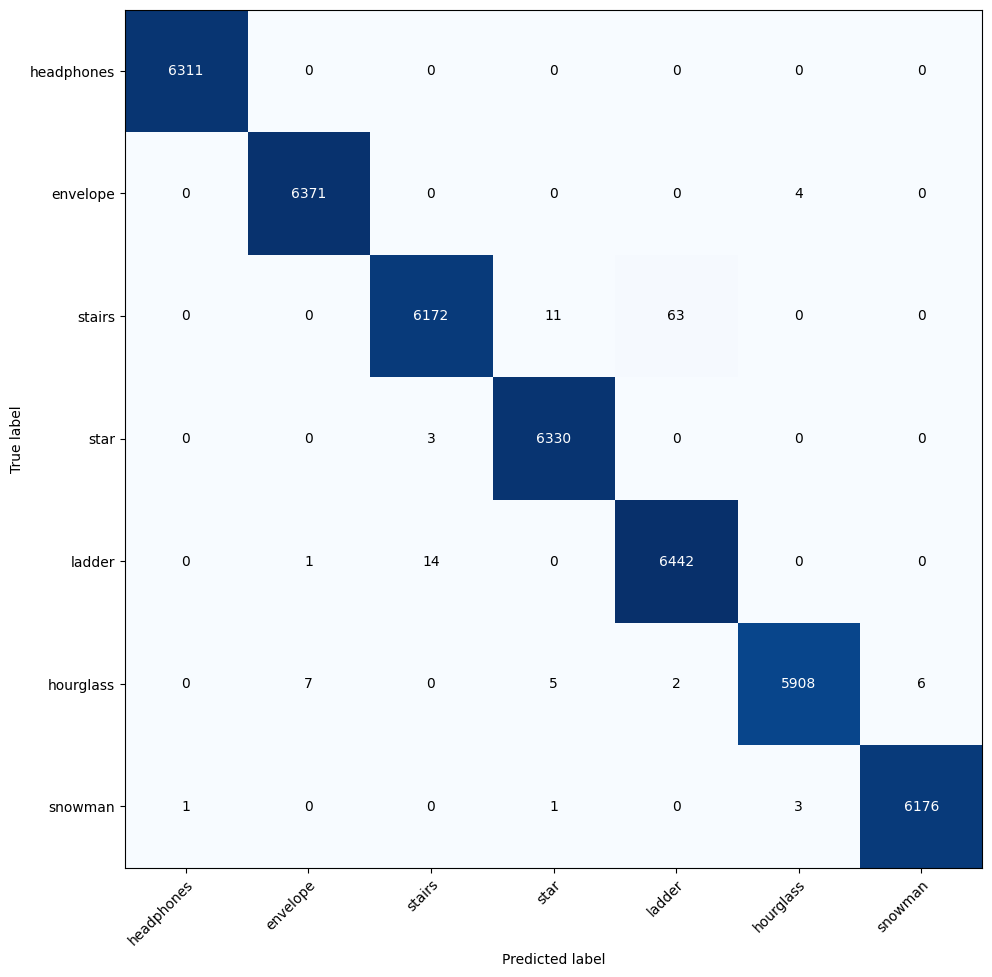

In [16]:
from sklearn.metrics import confusion_matrix
from itertools import compress
selected_classes = ["headphones", "envelope", "stairs", "star", "ladder", "hourglass", "snowman"]
mask = np.isin(y_prediction, selected_classes) & np.isin(y_true_labels, selected_classes)
print(mask[0:100])
cm = confusion_matrix(list(compress(y_true_labels, mask)), list(compress(y_prediction,mask)), labels=selected_classes)
print(cm)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=selected_classes, yticklabels=selected_classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

(28, 28, 1)
(1, 28, 28, 1)
<class 'numpy.ndarray'>
['cell_phone', 'telephone', 'remote_control', 'traffic_light', 'passport']


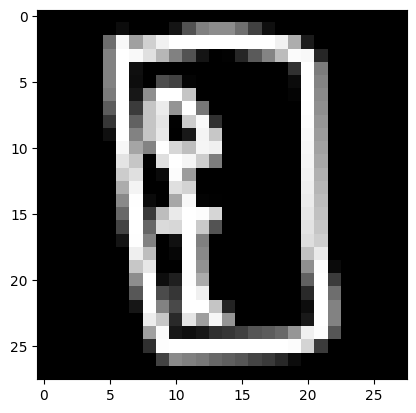

In [38]:
%matplotlib inline  
idx = randint(0, len(X_test))
img = X_test[idx]
print(img.shape)
plt.imshow(img.squeeze(), cmap='Greys_r') 
print(np.expand_dims(img, axis=0).shape)
pred = model.predict(np.expand_dims(img, axis=0))[0]
print(type(pred))
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)